# Seed Variation Analysis: Model Performance Stability

This notebook analyzes the stability of experimental results across different random seeds. It focuses on DINOv2-B-14 model using CLS+AP tokens from all layers with attentive pooling.

The analysis computes standard deviation of test balanced accuracy across multiple seeds for each dataset to assess result reproducibility.

**Output**: A bar chart displaying the standard deviation of test balanced accuracy for each dataset, with a reference line at 0.002 to highlight datasets with higher variance. Lower bars indicate more stable/reproducible results across different random seeds.


In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')
sys.path.append('../..')

from helper import add_additional_info, load_ds_info, save_or_show, init_plotting_params
from constants import ds_info_file, BASE_PATH_PROJECT, DS_ORDER, FOLDER_SUBSTRING

In [2]:
init_plotting_params()

{
  "agg.path.chunksize": 0,
  "axes.labelsize": 13.0,
  "axes.titlesize": 14.0,
  "axes3d.trackballsize": 0.667,
  "boxplot.flierprops.markersize": 6.0,
  "boxplot.meanprops.markersize": 6.0,
  "errorbar.capsize": 0.0,
  "figure.figsize": [
    6.4,
    4.8
  ],
  "figure.labelsize": "large",
  "figure.titlesize": "large",
  "font.cursive": [
    "Apple Chancery",
    "Textile",
    "Zapf Chancery",
    "Sand",
    "Script MT",
    "Felipa",
    "Comic Neue",
    "Comic Sans MS",
    "cursive"
  ],
  "font.family": [
    "sans-serif"
  ],
  "font.fantasy": [
    "Chicago",
    "Charcoal",
    "Impact",
    "Western",
    "xkcd script",
    "fantasy"
  ],
  "font.monospace": [
    "DejaVu Sans Mono",
    "Bitstream Vera Sans Mono",
    "Computer Modern Typewriter",
    "Andale Mono",
    "Nimbus Mono L",
    "Courier New",
    "Courier",
    "Fixed",
    "Terminal",
    "monospace"
  ],
  "font.sans-serif": [
    "DejaVu Sans",
    "Bitstream Vera Sans",
    "Computer Modern Sans Serif

In [ ]:
project_path = BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp"
storing_path = project_path / "plots" / "appendix_res_variation_seeds"
SAVE = 'both' 
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [4]:
ds_info = load_ds_info(ds_info_file)

In [5]:
res = []
for res_path in project_path.rglob('results.json'):    
    df = pd.read_json(res_path)
    df = add_additional_info(df)
    
    model_id_n_hopt_slug = "/".join(res_path.parts[10:-1])
    df['model_id_n_hopt_slug'] = model_id_n_hopt_slug
    df['res_folder'] = project_path.name

    res.append(df)
all_results = pd.concat(res).reset_index(drop=True)

In [6]:
filtered_all_results = all_results[
    (all_results['attention_dropout'] == '[0.0, 0.0]') & \
    (all_results['base_model'] == 'dinov2-vit-base-p14') & \
    (all_results['Experiment'] == "CLS+AP layers from all blocks (attentive)") & \
    (~all_results['dataset'].isin(['imagenet-subset-50k', 'wds/imagenet1k']))
    ].copy().reset_index(drop=True)

In [7]:
seed_info = filtered_all_results.groupby('dataset')['test_lp_bal_acc1'].describe().sort_index()
seed_info.index = [ds.replace("/", '_') for ds in seed_info.index]
seed_info.index = [ds_info.loc[ds, 'name'] for ds in seed_info.index]
seed_info = seed_info.loc[DS_ORDER,:]
seed_info = seed_info.sort_values('std')

/tmp/ipykernel_250625/3625978619.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');


stored image.


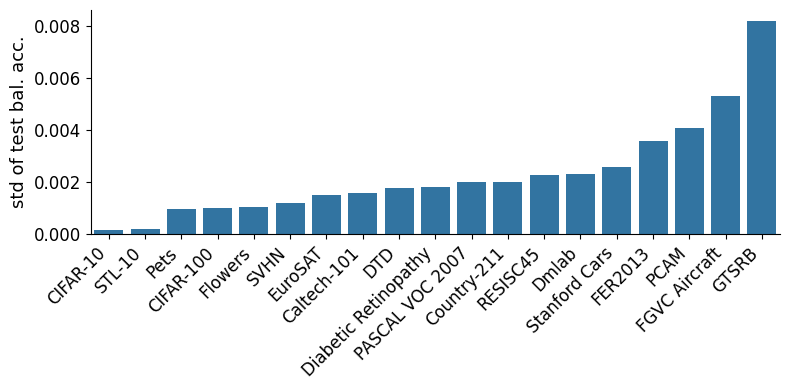

In [8]:
plt.figure(figsize=(8, 4))
g = sns.barplot(seed_info['std'])
g.set_xlabel('')
g.set_ylabel('std of test bal. acc.')
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right');
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)

plt.tight_layout()
fn = storing_path / f'std_test_bal_acc_dinov2_base_all_layers_cls_ap_attentive.pdf'
save_or_show(plt.gcf(), fn, SAVE)